## Term Project - Data Science and Machine Learning, University of Tokyo
###  Objective : "Leaf Based Plant Disease Classification"
### Name / ID : Hansen Hendra / 37-205127  


## Table of Contents:

* <font size="5">[Data Exploration](#EDA)</font><br><br>
    * <font size="3">[Brief Data Description](#data_desc)</font>
    * <font size="3">[Class Distribution](#class_dist)</font>
 

* <font size="5">[Shallow CNN Using Tensorflow Keras](#shallow)</font><br><br>
    * <font size="3">[Load Data and Batching](#shallow_batching)</font>
    * <font size="3">[CNN Architecture](#shallow_arch)</font>
    * <font size="3">[Evaluation](#shallow_evaluation)</font> <br>
 

* <font size="5">[ResNet-9 Using Pytorch](#resnet)</font><br><br>
    * <font size="3">[Load Data and Batching](#resnet_batching)</font>
    * <font size="3">[Setting up GPU/CPU](#resnet_gpu)</font>
    * <font size="3">[CNN Architecture](#resnet_arch)</font>
    * <font size="3">[Evaluation](#resnet_evaluation)</font> <br>

## Data Exploration <a class="anchor" id="EDA"></a>

### Brief Data Description <a class="anchor" id="data_desc"></a>

Dataset is given by augmentation available on Kaggle https://www.kaggle.com/qramkrishna/corn-leaf-infection-dataset , the real dataset origin is PlantVillage Dataset  https://github.com/spMohanty/PlantVillage-Dataset 

### Class Distribution<a class="anchor" id="class_dist"></a>

In [1]:
#Basic Library to access directory, import dataframe, and visualization

import os                       
import numpy as np              
import pandas as pd           
import matplotlib.pyplot as plt 
from time import perf_counter 
%matplotlib inline

* From Kaggle it was given:
    * 80% Training Dataset: 70K
    * 20% Validation Datset :16K
    * Test Data : 33 images only
    
But since there is 38 classes, <strong>doing with only 33 test images is insufficient</strong>. Therefore, <strong>Validation set is split half for validation and test dataset</strong>

In [2]:
#Exploring directory
data_dir = "./dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/tests"




folder_names = os.listdir(train_dir)
print("Total classes in the dataset\t: ", len(folder_names))

train_data_number = sum([len(files) for r, d, files in os.walk(train_dir)])
validation_data_number = sum([len(files) for r, d, files in os.walk(valid_dir)])
test_data_number = sum([len(files) for r, d, files in os.walk(test_dir)])

print('Train dataset number\t\t: ', train_data_number)
print('Validation dataset number\t: ', validation_data_number)
print('Test dataset number\t\t: ', test_data_number)

Total classes in the dataset	:  38
Train dataset number		:  70295
Validation dataset number	:  8795
Test dataset number		:  8777


Validation and Test Dataset are both 10% of total dataset

In [3]:
#function to split the plant name and disease name, customized based on the dataset text format
def get_name_disease(input_text):
    return input_text.split('___')[0], input_text.split('___')[1]

In [4]:
plants_name = []
diseases_name = []
for folder_name in folder_names:
    plant,disease = get_name_disease(folder_name)
    if plant not in plants_name:
        plants_name.append(plant)
    if disease != 'healthy':
        diseases_name.append(disease)

plant_number = len(plants_name)
disease_number = len(diseases_name)

print('plants number: ', plant_number,'\t diseases number : ', disease_number)

plants number:  14 	 diseases number :  26


In [5]:
# Shows Dataframes with Plant, Disease, and Number of Images
dist_df = pd.DataFrame(columns=['Plant_Disease','Plant','Disease','Number of Images'])
for folder_name in folder_names:
    plant,disease = get_name_disease(folder_name)
    number_images = len(os.listdir(os.path.join(train_dir,folder_name)))
    data = [folder_name,plant,disease, number_images]
    dist_df.loc[len(dist_df)]=data

dist_df.sort_values(['Plant','Disease'], inplace=True)
dist_df.reset_index(drop=True,inplace=True)

In [6]:
dist_df

,Plant_Disease,Plant,Disease,Number of Images
0,Apple___Apple_scab,Apple,Apple_scab,2016
1,Apple___Black_rot,Apple,Black_rot,1987
2,Apple___Cedar_apple_rust,Apple,Cedar_apple_rust,1760
3,Apple___healthy,Apple,healthy,2008
4,Blueberry___healthy,Blueberry,healthy,1816
5,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour),Powdery_mildew,1683
6,Cherry_(including_sour)___healthy,Cherry_(including_sour),healthy,1826
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,1642
8,Corn_(maize)___Common_rust_,Corn_(maize),Common_rust_,1907
9,Corn_(maize)___Northern_Leaf_Blight,Corn_(maize),Northern_Leaf_Blight,1908


Blueberry has just 1 class (healthy), while others plants has multiple condition like tomato has 10 diseases

<Figure size 432x288 with 0 Axes>

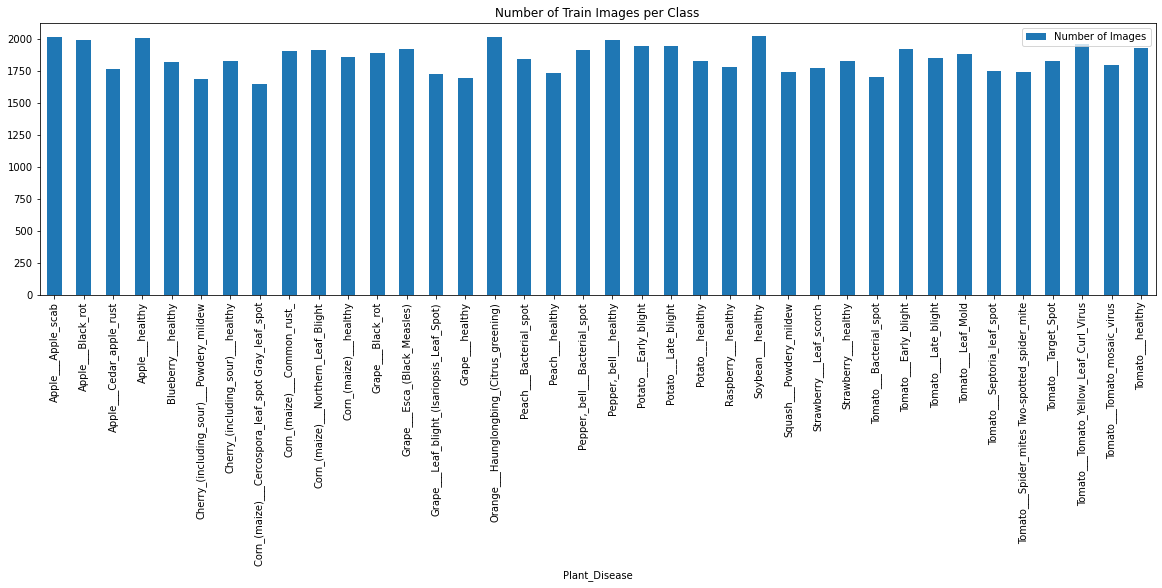

In [7]:
plt.figure()
ax = dist_df.plot.bar(x='Plant_Disease', y='Number of Images', rot=90,figsize=(20, 5), title='Number of Train Images per Class')

Summary of the Data Exploration:

Plants Number : 14
Disease Number : 26
Total classes (combination between plant and disease) : 38, <strong>highly balanced</strong>

Training will be based on just 38 classes, <strong>balanced dataset is highly more favorable than using classification separate between fruit and disease (imbalanced). Validation and Test set are checked to be balanced as well</strong>

## Shallow CNN <a class="anchor" id="shallow"></a>

Tensorflow based Keras is used.

In [24]:
# Tensorflow and keras layers for NN
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import image


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import cv2

### Load Data and Batching <a class="anchor" id="shallow_batching"></a>

In [25]:
## Defining batch specfications
batch_size = 16
img_height = 256
img_width = 256

In [26]:
## loading training set
training_batch = tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 70295 files belonging to 38 classes.


In [27]:
## loading validation dataset
validation_batch =  tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/valid',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 8795 files belonging to 38 classes.


In [28]:
## loading validation dataset
validation_batch =  tf.keras.preprocessing.image_dataset_from_directory(
    './dataset/tests',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 8777 files belonging to 38 classes.


In [29]:
#show the first batch
i=1
for element in training_batch:
    print(element)
    if i==1:
        break

(<tf.Tensor: shape=(16, 256, 256, 3), dtype=float32, numpy=
array([[[[148., 128., 127.],
         [171., 151., 150.],
         [170., 150., 149.],
         ...,
         [201., 183., 183.],
         [183., 165., 165.],
         [187., 169., 169.]],

        [[158., 138., 137.],
         [155., 135., 134.],
         [148., 128., 127.],
         ...,
         [191., 173., 173.],
         [180., 162., 162.],
         [179., 161., 161.]],

        [[185., 165., 164.],
         [162., 142., 141.],
         [150., 130., 129.],
         ...,
         [175., 157., 157.],
         [189., 171., 171.],
         [191., 173., 173.]],

        ...,

        [[106.,  94.,  82.],
         [ 99.,  87.,  75.],
         [ 95.,  83.,  71.],
         ...,
         [100.,  88.,  74.],
         [121., 104.,  94.],
         [152., 135., 125.]],

        [[106.,  94.,  82.],
         [ 98.,  86.,  74.],
         [ 93.,  81.,  69.],
         ...,
         [ 45.,  36.,  21.],
         [ 46.,  34.,  22.],
       

In [30]:
class_names = training_batch.class_names
class_names[:4]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

### CNN Architecture and Training <a class="anchor" id="shallow_arch"></a>

In [32]:
## Defining Cnn
MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])


In [33]:
MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
PATH_model = './result/shallow_cnn_best_model_second.h5'
mc = ModelCheckpoint(PATH_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [35]:
%%time
history_shallow_CNN = MyCnn.fit(training_batch,validation_data= validation_batch,epochs = 30,callbacks=[es, mc])

Epoch 1/30
4394/4394 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.7324
Epoch 00001: val_accuracy improved from -inf to 0.85040, saving model to ./result/shallow_cnn_best_model_second.h5
4394/4394 [==============================] - 187s 43ms/step - loss: 0.9002 - accuracy: 0.7324 - val_loss: 0.4880 - val_accuracy: 0.8504
Epoch 2/30
4392/4394 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.9142
Epoch 00002: val_accuracy improved from 0.85040 to 0.89085, saving model to ./result/shallow_cnn_best_model_second.h5
4394/4394 [==============================] - 175s 40ms/step - loss: 0.2733 - accuracy: 0.9142 - val_loss: 0.4099 - val_accuracy: 0.8909
Epoch 3/30
4393/4394 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9509
Epoch 00003: val_accuracy improved from 0.89085 to 0.90475, saving model to ./result/shallow_cnn_best_model_second.h5
4394/4394 [==============================] - 176s 40ms/step - loss: 0.1547 - accura

In [36]:
# history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es, mc])


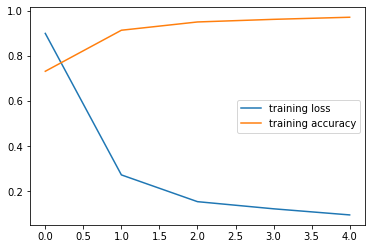

In [39]:
plt.plot(history_shallow_CNN.history['loss'], label = 'training loss')
plt.plot(history_shallow_CNN.history['accuracy'], label = 'training accuracy')
plt.legend()

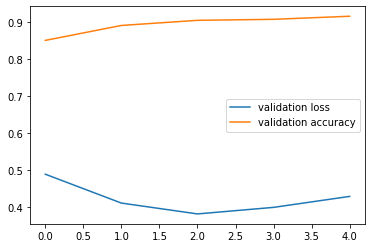

In [40]:
plt.plot(history_shallow_CNN.history['val_loss'], label = 'validation loss')
plt.plot(history_shallow_CNN.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

## Testing

In [41]:
# # load model
# PATH_model = './result/shallow_cnn_best_model.h5'
# loaded_model = load_model(PATH_model)
# loaded_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
loaded_model=MyCnn

In [43]:
#Exploring directory
data_dir = "./dataset"
test_dir = data_dir + "/train"
# test_dir = data_dir + "/tests"
#Get labels
test_subfolders = os.listdir(test_dir)
test_subfolders.sort()

In [44]:
label = 0
label_list = []
predicted_list = []
for test_subfolder in test_subfolders[:4]:

    print(test_subfolder)
    current_folder = os.path.join(test_dir, test_subfolder)
#     label = os.listdir(current_folder)[0]
    current_folder_inside = current_folder
    current_files = os.listdir(current_folder_inside)
    current_file = os.path.join(current_folder_inside,current_files[0])
    
    for current_file in current_files:
        imgPath = os.path.join(current_folder_inside,current_file)

        img = cv2.imread(imgPath)
        img = cv2.resize(img,(256,256))
        img = np.reshape(img,[1,256,256,3])

        label_list.append(label)
        predicted = np.argmax(loaded_model.predict(img), axis = -1)[0]
    #     predicted = np.argmax(MyCnn.predict(img), axis = -1)[0]
        predicted_list.append(predicted)
    
    label +=1

Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy


In [45]:
from sklearn.metrics import classification_report

print(classification_report(label_list, predicted_list))

              precision    recall  f1-score   support

           0       0.47      0.21      0.29      2016
           1       0.92      0.53      0.67      1987
           2       0.92      0.14      0.25      1760
           3       0.80      0.60      0.69      2008
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          19       0.00    

In [46]:
#Exploring directory
data_dir = "./dataset"
# test_dir = data_dir + "/train"
test_dir = data_dir + "/tests"
#Get labels
test_subfolders = os.listdir(test_dir)
test_subfolders.sort()

In [47]:
label_list = []
predicted_list = []
for test_subfolder in test_subfolders:

    print(test_subfolder)
    current_folder = os.path.join(test_dir, test_subfolder)
    label = os.listdir(current_folder)[0]
    label_int = int(label)
    current_folder_inside = os.path.join(current_folder, label)
    current_files = os.listdir(current_folder_inside)
    current_file = os.path.join(current_folder_inside,current_files[0])
    
    for current_file in current_files:
        imgPath = os.path.join(current_folder_inside,current_file)

        img = cv2.imread(imgPath)
        img = cv2.resize(img,(256,256))
        img = np.reshape(img,[1,256,256,3])

        label_list.append(label_int)
        predicted = np.argmax(loaded_model.predict(img), axis = -1)[0]
    #     predicted = np.argmax(MyCnn.predict(img), axis = -1)[0]
        predicted_list.append(predicted)

Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry_(including_sour)___Powdery_mildew
Cherry_(including_sour)___healthy
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Corn_(maize)___Northern_Leaf_Blight
Corn_(maize)___healthy
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Grape___healthy
Orange___Haunglongbing_(Citrus_greening)
Peach___Bacterial_spot
Peach___healthy
Pepper,_bell___Bacterial_spot
Pepper,_bell___healthy
Potato___Early_blight
Potato___Late_blight
Potato___healthy
Raspberry___healthy
Soybean___healthy
Squash___Powdery_mildew
Strawberry___Leaf_scorch
Strawberry___healthy
Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___healthy


In [48]:
from sklearn.metrics import classification_report

print(classification_report(label_list, predicted_list))

              precision    recall  f1-score   support

           0       0.22      0.19      0.20       252
           1       0.69      0.51      0.59       248
           2       0.65      0.09      0.16       220
           3       0.14      0.57      0.23       251
           4       0.67      0.15      0.25       227
           5       0.52      0.07      0.13       210
           6       0.24      0.02      0.04       228
           7       0.83      0.19      0.30       205
           8       0.99      0.46      0.63       238
           9       1.00      0.02      0.03       238
          10       0.52      1.00      0.69       232
          11       0.48      0.39      0.43       236
          12       0.57      0.03      0.06       240
          13       0.29      0.02      0.03       215
          14       0.36      0.85      0.51       211
          15       0.00      0.00      0.00       251
          16       0.37      0.13      0.19       229
          17       0.83    

## ResNet-9 Using Pytorch <a class="anchor" id="resnet"></a>

In [8]:
import torch                    
import torch.nn as nn           
from torch.utils.data import DataLoader 
from PIL import Image          
import torch.nn.functional as F 
import torchvision.transforms as transforms   
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary              

### Load Data and Batching <a class="anchor" id="resnet_batching"></a>

In [9]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

This function converts directory of datasets to format of dataset used by torchvision. <br>The label is directly taken from the subfolder name. <br><strong>Label is directly changed to ordinal number (0-number of classes-1)</strong>

In [10]:
img, label = train[0]
print(img.shape, label,len(train.classes))

torch.Size([3, 256, 256]) 0 38


The torch size is 256x256 RGB Channel with 38 classes

Label :Apple___Apple_scab(0)


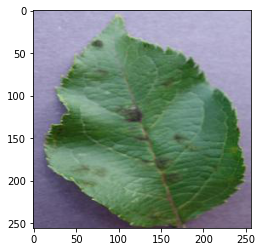

In [11]:
# Example showing an image and the label from torch
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
show_image(*train[0])

In [12]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

#### Batching

In [13]:
# batch_size = 32
batch_size = 16
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=4, pin_memory=True)

In [14]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

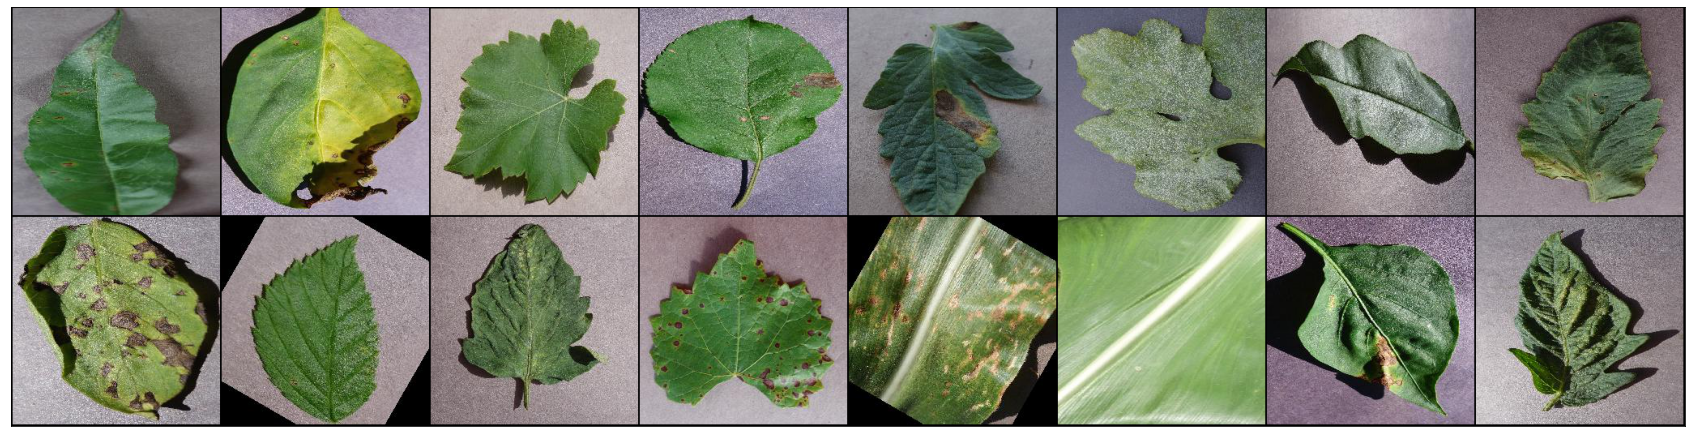

In [15]:
# Images for first batch of training
show_batch(train_dl) 

### Setting up GPU/CPU <a class="anchor" id="resnet_gpu"></a>

The experiment is conducted on Laboratory PC, with NVIDIA RTX 2080 GPU.
Move every data to GPU

In [16]:
# getting the gpu
def get_default_device():
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# moving data to GPU if available
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# loading the GPU
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device      
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)    
    def __len__(self):
        return len(self.dl)
    
device = get_default_device()
print('We are working with : ',device)

# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

We are working with :  cuda


### CNN Architecture <a class="anchor" id="resnet_arch"></a>

**ResNet** stands for Residual Net was introduced in 2015. It is a deep CNN with special residual block that has the identity skip connection that directly added to next layer with the residual function itself. This is proved to be an effective way to avoid overfitting and preventing vanishing gradient descent that usually happens on deep layer network.

![image](https://www.mdpi.com/remotesensing/remotesensing-11-01896/article_deploy/html/images/remotesensing-11-01896-g001.png)

In [17]:
# In this section, we implement function for evaluating the loss and accuracy for each step of batch training
# Cross entropy is widely used for images multi label classification

# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [18]:
# Architecture for training

# This adds the batch normalization for residual block function defined in ResNet
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [19]:
# Move the model to GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

*Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the `torchsummary` library (discussed earlier)*

In [20]:
# Summary of model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

## Model Training

Utility function `evaluate` is used to define the accuracy on specific data, while `fit_one_cycle` is when all the training happens, with some techniques that can be easily implemented in Pytorch

- **Learning Rate Scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we’ll use is called the *“One Cycle Learning Rate Policy”*, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

- **Weight Decay**: We also use weight decay, which is a regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. 

- **Gradient Clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

We'll also record the learning rate used for each batch.

In [21]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,patience=2,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    epoch_no_improve = 0
    min_val_loss = 100000
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        
        if result['val_loss']<min_val_loss:
            min_val_loss = result['val_loss']
            epoch_no_improve=0
            
        if result['val_loss']>min_val_loss:
            epoch_no_improve +=1
            if epoch_no_improve == patience:
                print('Early stopping!' )
                break
        
        print(result['val_loss'], min_val_loss)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [69]:
# if val_loss < min_val_loss:
#   #Saving the model
#   if min_loss > loss.item():
#     min_loss = loss.item()
#     best_model = copy.deepcopy(loaded_model.state_dict())
#     print('Min loss %0.2f' % min_loss)
#   epochs_no_improve = 0
#   min_val_loss = val_loss

# else:
#   epochs_no_improve += 1
#   # Check early stopping condition
#   if epochs_no_improve == n_epochs_stop:
#     print('Early stopping!' )
#     loaded_model.load_state_dict(best_model)


In [70]:
# # for training
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)


# def get_lr(optimizer):
#     for param_group in optimizer.param_groups:
#         return param_group['lr']
    

# def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,n_epochs_stop=2,
#                 grad_clip=None, opt_func=torch.optim.SGD):
#     torch.cuda.empty_cache()
#     history = []
    
#     optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
#     # scheduler for one cycle learniing rate
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
#     #previous loss
#     last_loss = 1000000
#     epochs_no_improve =0
#     for epoch in range(epochs):
#         print('epochs number : ', epoch)
#         # Training
#         model.train()
#         train_losses = []
#         lrs = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
            
#             # gradient clipping
#             if grad_clip: 
#                 nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
#             optimizer.step()
#             optimizer.zero_grad()
            
#             # recording and updating learning rates
#             lrs.append(get_lr(optimizer))
#             sched.step()
            
    
#         # validation
#         result = evaluate(model, val_loader)
#         train_loss = torch.stack(train_losses).mean().item()
#         if(train_loss>=last_loss):
#             epochs_no_improve+=1
        
#         if epochs_no_improve == n_epochs_stop:
#             print('Early stopping!' )
#             early_stop = True
#             break
#         result['train_loss'] = train_loss
#         result['lrs'] = lrs
#         model.epoch_end(epoch, result)
#         history.append(result)
            
            

        
#     return history
    

In [22]:
%%time
# Evaluate on Validation Dataset with random initialized weight and bias

history = [evaluate(model, valid_dl)]
history

CPU times: user 21.9 s, sys: 1.22 s, total: 23.1 s
Wall time: 21 s


[{'val_loss': tensor(3.6399, device='cuda:0'), 'val_accuracy': tensor(0.0188)}]

In [72]:
# Obviously the accuracy is really bad because the training has yet to happen. Define the epochs, learning rate, gradient clip, and weight decay
epochs = 30
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [73]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

tensor(0.8646, device='cuda:0') tensor(0.8646, device='cuda:0')
Epoch [0], last_lr: 0.00280, train_loss: 0.7074, val_loss: 0.8646, val_acc: 0.7807
tensor(1.1646, device='cuda:0') tensor(0.8646, device='cuda:0')
Epoch [1], last_lr: 0.00760, train_loss: 0.4480, val_loss: 1.1646, val_acc: 0.6752
tensor(0.4419, device='cuda:0') tensor(0.4419, device='cuda:0')
Epoch [2], last_lr: 0.01000, train_loss: 0.3722, val_loss: 0.4419, val_acc: 0.8649
tensor(0.6599, device='cuda:0') tensor(0.4419, device='cuda:0')
Epoch [3], last_lr: 0.00950, train_loss: 0.3054, val_loss: 0.6599, val_acc: 0.8001
tensor(0.2321, device='cuda:0') tensor(0.2321, device='cuda:0')
Epoch [4], last_lr: 0.00812, train_loss: 0.2607, val_loss: 0.2321, val_acc: 0.9274
tensor(0.1733, device='cuda:0') tensor(0.1733, device='cuda:0')
Epoch [5], last_lr: 0.00611, train_loss: 0.2064, val_loss: 0.1733, val_acc: 0.9493
tensor(0.0823, device='cuda:0') tensor(0.0823, device='cuda:0')
Epoch [6], last_lr: 0.00389, train_loss: 0.1490, val_l

Training Deep CNN like ResNet in lest than 18 minutes with over than 98% validation accuracy is quite successful

# 📈 Plotting 📈

#### Helper functions for plotting

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

### Loss Per Epochs

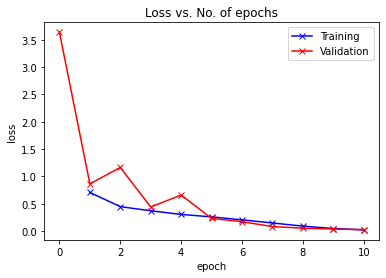

In [75]:
plot_losses(history)

### Learning Rate “One Cycle Learning Rate Policy”

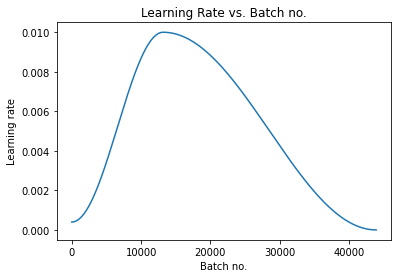

In [76]:
plot_lrs(history)

### Evaluation <a class="anchor" id="resnet_evaluation"></a>

In [77]:
# # Load model if alreadt exist
# PATH = './result/plant-disease-model.pth'  
# model_load = torch.load(PATH)
# model = model_load

In [26]:
# Load model if alreadt exist
PATH = './result/resnet-model-complete-10-epochs.pth'
model_load = torch.load(PATH)
model = model_load

In [27]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train.classes[preds[0].item()], preds[0].item()

In [28]:
#Exploring directory
data_dir = "./dataset"
test_dir = data_dir + "/tests"
#Get labels
test_subfolders = os.listdir(test_dir)
test_subfolders.sort()

In [29]:
# Uncomment this if model already exists

# PATH_model = './result/resnet-model-complete.pth'
# new_model = torch.load(PATH_model)
# model=new_model

In [30]:
k=0
labels = []
predicted = []
label_predicted = []
for test_subfolder in test_subfolders:
    wrong_prediction = 0
    print('class : ',k,'\tlabel : ', test_subfolder,'\n')
    subfolder_dir = os.path.join(test_dir,test_subfolder)
    test = ImageFolder(subfolder_dir, transform=transforms.ToTensor())
    for i, (img, label) in enumerate(test):
        pred_text, pred_label = predict_image(img, model)
        if pred_label != k: #wrong prediction
            wrong_prediction +=1
        label_predicted.append([k,pred_label])
        labels.append(k)
        predicted.append(pred_label)
    print('class member : ',i,'\twrong predicted',wrong_prediction) 
    k+=1
    

class :  0 	label :  Apple___Apple_scab 

class member :  251 	wrong predicted 2
class :  1 	label :  Apple___Black_rot 

class member :  247 	wrong predicted 0
class :  2 	label :  Apple___Cedar_apple_rust 

class member :  219 	wrong predicted 0
class :  3 	label :  Apple___healthy 

class member :  250 	wrong predicted 2
class :  4 	label :  Blueberry___healthy 

class member :  226 	wrong predicted 1
class :  5 	label :  Cherry_(including_sour)___Powdery_mildew 

class member :  209 	wrong predicted 1
class :  6 	label :  Cherry_(including_sour)___healthy 

class member :  227 	wrong predicted 1
class :  7 	label :  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 

class member :  204 	wrong predicted 9
class :  8 	label :  Corn_(maize)___Common_rust_ 

class member :  237 	wrong predicted 1
class :  9 	label :  Corn_(maize)___Northern_Leaf_Blight 

class member :  237 	wrong predicted 3
class :  10 	label :  Corn_(maize)___healthy 

class member :  231 	wrong predicted 0
class 

## Save Model

In [84]:
# PATH_model = './result/resnet-model-complete-10-epochs.pth'
# torch.save(model, PATH_model)

## F1 Score

In [31]:
from sklearn.metrics import classification_report

print(classification_report(labels, predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       252
           1       0.99      1.00      0.99       248
           2       0.98      1.00      0.99       220
           3       0.99      0.99      0.99       251
           4       1.00      1.00      1.00       227
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       228
           7       0.99      0.96      0.97       205
           8       1.00      1.00      1.00       238
           9       0.97      0.99      0.98       238
          10       1.00      1.00      1.00       232
          11       1.00      1.00      1.00       236
          12       1.00      1.00      1.00       240
          13       1.00      1.00      1.00       215
          14       1.00      1.00      1.00       211
          15       1.00      0.99      1.00       251
          16       1.00      0.99      0.99       229
          17       0.99    

It is clear that, Resnet9 architecture is excellent for doing leaf based disease classification. The macro avg and weighted macro avg has the same accuracy is obvious because the class is balanced.